Этот ноутбук посвящен вступительному заданию на кафедру корпоративных систем ФПМИ МФТИ.
Цель - предсказать количество заболевших вирусом SARS-CoV-2 на территории США на 16.04.2020 на основании данных по 12.04.2020. Данные взяты [здесь](https://github.com/nytimes/covid-19-data) (данные The New York Times). Ссылки оттуда лучше открывать под американским впн, а то американцы, кажется, не любят русским данные давать:)

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from matplotlib.dates import date2num, DateFormatter
%matplotlib inline

Загрузим датасет

In [144]:
covid = pd.read_csv('us-counties.csv', index_col='date')

In [145]:
covid.head(10)

,county,state,fips,cases,deaths
date,,,,,
2020-01-21,Snohomish,Washington,53061.0,1,0
2020-01-22,Snohomish,Washington,53061.0,1,0
2020-01-23,Snohomish,Washington,53061.0,1,0
2020-01-24,Cook,Illinois,17031.0,1,0
2020-01-24,Snohomish,Washington,53061.0,1,0
2020-01-25,Orange,California,6059.0,1,0
2020-01-25,Cook,Illinois,17031.0,1,0
2020-01-25,Snohomish,Washington,53061.0,1,0
2020-01-26,Maricopa,Arizona,4013.0,1,0


Ага, у нас есть данные по городам и штатам. Но для начала попробуем проанализировать данные заболевших и смертей суммарно по всей стране

In [146]:
covid_total = covid.groupby('date').sum()

In [147]:
covid_total.tail(10)

,fips,cases,deaths
date,,,
2020-04-03,69388023.0,276201,7136
2020-04-04,70752270.0,310842,8505
2020-04-05,71835852.0,336410,9661
2020-04-06,73133230.0,366362,11709
2020-04-07,74975534.0,397752,12959
2020-04-08,75907246.0,429283,14779
2020-04-09,76939136.0,463689,16685
2020-04-10,78022155.0,496904,18720
2020-04-11,78961112.0,528422,20579


Ну что, построим графики. Сначала для всего отрезка, а там видно будет

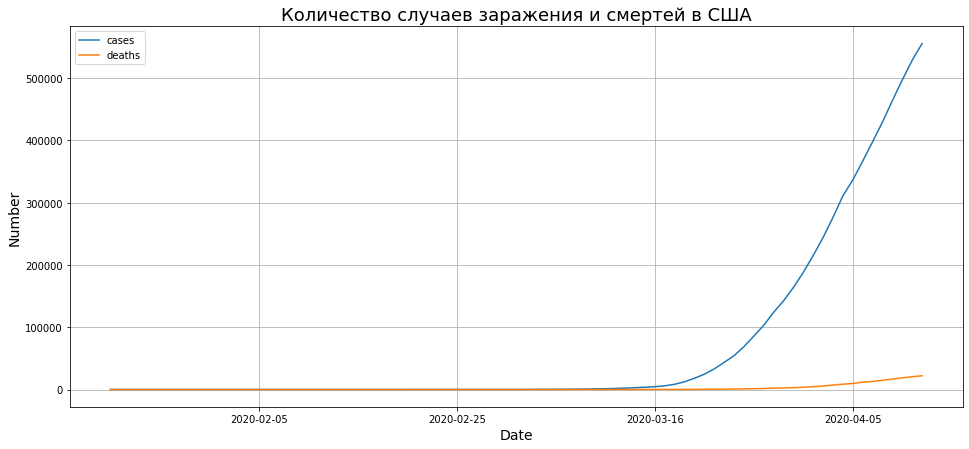

In [148]:
fig, ax = plt.subplots(figsize=(16, 7))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.set_title('Количество случаев заражения и смертей в США', fontdict={'size': 18})
ax.set_ylabel('Number', fontdict={'size': 14})
ax.set_xlabel('Date', fontdict={'size': 14})
ax.plot(date2num(pd.to_datetime(covid_total.index).to_pydatetime()), covid_total.cases, label='cases')
ax.plot(date2num(pd.to_datetime(covid_total.index).to_pydatetime()), covid_total.deaths, label='deaths')
ax.legend(loc='best')
plt.grid(which='both')
plt.show()

Что-то не очень показательно. Видно, что что-то похожее на экспоненту, но не более того. Давайте в логарифмическом масштабе где-нибудь с середины марта смотреть.

In [149]:
covid_total_march = covid_total['2020-03-15':]

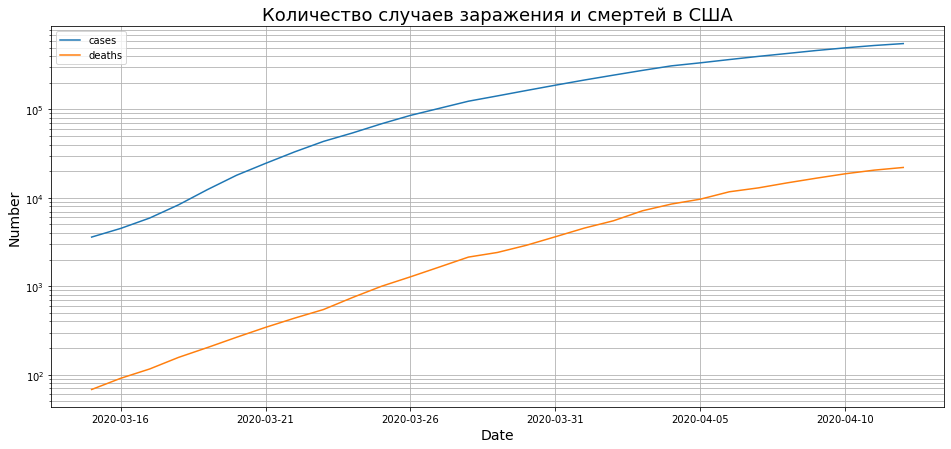

In [150]:
fig, ax = plt.subplots(figsize=(16, 7))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.set_title('Количество случаев заражения и смертей в США', fontdict={'size': 18})
ax.set_ylabel('Number', fontdict={'size': 14})
ax.set_xlabel('Date', fontdict={'size': 14})
plt.yscale('log')
ax.plot(date2num(pd.to_datetime(covid_total_march.index).to_pydatetime()),
        covid_total_march.cases, label='cases')
ax.plot(date2num(pd.to_datetime(covid_total_march.index).to_pydatetime()),
        covid_total_march.deaths, label='deaths')
ax.legend(loc='best')
plt.grid(which='both')
plt.show()

Видно, что показатель экспоненты постепенно уменьшается, но достаточно медленно. Давайте попробуем взять данные только за апрель, усредним показатель экспоненты и попробуем предсказать на основании этого показателя. Тогда должно получиться число не меньше реального.

In [151]:
covid_total_april = covid_total['2020-04-01':]

In [152]:
covid_total_april

,fips,cases,deaths
date,,,
2020-04-01,65474284.0,215013,4551
2020-04-02,67381553.0,244007,5502
2020-04-03,69388023.0,276201,7136
2020-04-04,70752270.0,310842,8505
2020-04-05,71835852.0,336410,9661
2020-04-06,73133230.0,366362,11709
2020-04-07,74975534.0,397752,12959
2020-04-08,75907246.0,429283,14779
2020-04-09,76939136.0,463689,16685


In [153]:
cases = covid_total_april['cases'].to_numpy()

In [154]:
cases_log = np.log(cases)

In [155]:
cases, cases_log

(array([215013, 244007, 276201, 310842, 336410, 366362, 397752, 429283,
        463689, 496904, 528422, 555374]),
 array([12.27845377, 12.40495219, 12.52888414, 12.64704002, 12.72608593,
        12.81137719, 12.89358397, 12.96987165, 13.04696935, 13.11615213,
        13.17765049, 13.22739704]))

In [156]:
dates = np.linspace(1, len(cases_log), len(cases_log))
dates

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [157]:
# приближаем полиномом 1 степени - считай линейно
fp, residuals, rank, sv, rcond = sp.polyfit(dates, cases_log, 1, full=True)

In [158]:
predictor = sp.poly1d(fp)

In [159]:
new_dates = np.linspace(1, len(cases) + 4, len(cases) + 4)
predicted_cases = np.exp(predictor(new_dates))

In [160]:
predicted_cases.astype(np.int64)

array([231284, 251809, 274155, 298485, 324973, 353812, 385211, 419395,
       456614, 497135, 541252, 589284, 641579, 698514, 760503, 827992])

In [161]:
new_dates_str = np.concatenate((covid_total_april.index.to_numpy(), np.array(['2020-04-' + str(i) for i in range(13, 17)])))

In [162]:
new_dates_str

array(['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
       '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
       '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12',
       '2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16'],
      dtype=object)

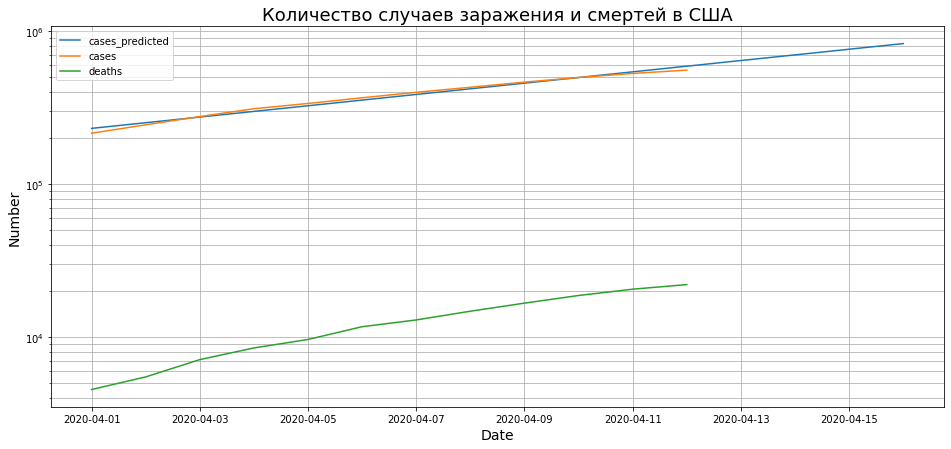

In [163]:
fig, ax = plt.subplots(figsize=(16, 7))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.set_title('Количество случаев заражения и смертей в США', fontdict={'size': 18})
ax.set_ylabel('Number', fontdict={'size': 14})
ax.set_xlabel('Date', fontdict={'size': 14})
plt.yscale('log')
ax.plot(date2num(pd.to_datetime(new_dates_str).to_pydatetime()),
        predicted_cases, label='cases_predicted')
ax.plot(date2num(pd.to_datetime(covid_total_april.index).to_pydatetime()),
        covid_total_april.cases, label='cases')
ax.plot(date2num(pd.to_datetime(covid_total_april.index).to_pydatetime()),
        covid_total_april.deaths, label='deaths')
ax.legend(loc='best')
plt.grid(which='both')
plt.show()

Получили первое приближение: 827992 человека. Но по графикам что-то плохо откровенно говоря. Это и понятно - показатель экспоненты же уменьшается. Давайте попробуем с полиномами большей степени. И возьмём базу побольше

Prediction on 1 dimensional: 971269
Prediction on 2 dimensional: 619945
Prediction on 3 dimensional: 652624


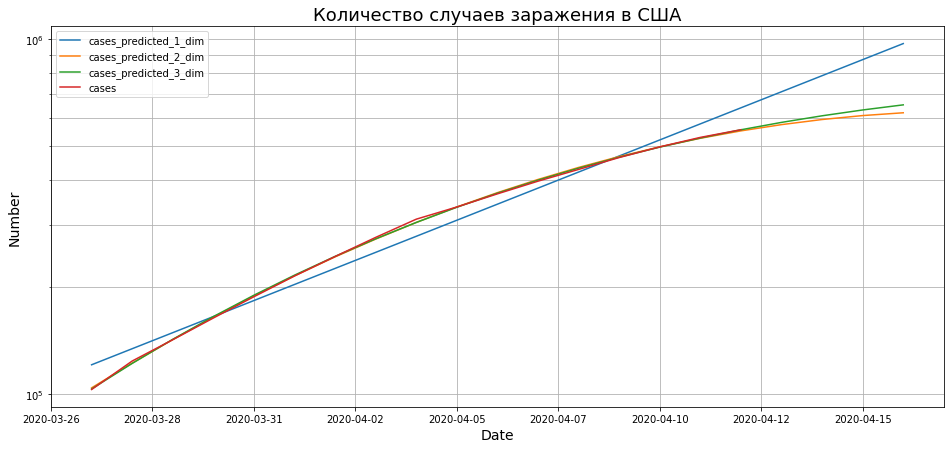

In [176]:
covid_work = covid_total['2020-03-27':]
cases = covid_work.cases.to_numpy()
cases_log = np.log(cases)
dates = np.linspace(1, len(cases_log), len(cases_log))
new_dates = np.linspace(1, len(cases_log) + 4, len(cases_log) + 4)

new_dates_str = np.concatenate((covid_work.index.to_numpy(), np.array(['2020-04-' + str(i) for i in range(13, 17)])))

fig, ax = plt.subplots(figsize=(16, 7))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.set_title('Количество случаев заражения в США', fontdict={'size': 18})
ax.set_ylabel('Number', fontdict={'size': 14})
ax.set_xlabel('Date', fontdict={'size': 14})
plt.yscale('log')

for i in range(1, 4):
    # приближаем полиномом 1 степени - считай линейно
    fp, residuals, rank, sv, rcond = sp.polyfit(dates, cases_log, i, full=True)
    predictor = sp.poly1d(fp)
    predicted_cases = np.exp(predictor(new_dates)).astype(np.int64)
    print('Prediction on {} dimensional: {}'.format(i, predicted_cases[-1]))
    ax.plot(date2num(pd.to_datetime(new_dates_str).to_pydatetime()),
            predicted_cases, label='cases_predicted_' + str(i) + '_dim')

ax.plot(date2num(pd.to_datetime(covid_work.index).to_pydatetime()),
        covid_work.cases, label='cases')
ax.legend(loc='best')
plt.grid(which='both')
plt.show()

Таким образом, получили целых 3 числа: 971269, 619945 и 652624. Первому нельзя доверять и мы уже поняли, почему. Давайте разберемся с оставшимися. 619945 соотвествует линейному убыванию показателей экспоненты, 652624 - более сложной зависимости (вообще говоря - непонятно какой).

Давайте подумаем о том, что вообще такое - показатель экспоненты. Это - количество людей, которые заражаются от какого-то одного человека (в среднем). Люди могут заразиться где угодно: дома, на улице, в магазине, даже в больнице. Однако, с каждым днём все больше людей понимают, что принцип "моя хата с краю" не работает и сокращают выходы на улицу и т.п. Поэтому я считаю, что убывание показателя должно быть линейным и наиболее правильным является значение 619945 человек.


Однако, тут вообще не учитывается фактор местности. По-хорошему считать отдельно хотя бы по штатам, а лучше и по городам. Доделаю, если успею:)